In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from tqdm import tqdm
from IPython.display import Image

In [3]:
import matplotlib.pyplot as plt
from keras import layers
import keras

In C:\Users\Akshay\.conda\envs\pytorchenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Akshay\.conda\envs\pytorchenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Akshay\.conda\envs\pytorchenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [1]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model_s = SentenceTransformer('all-mpnet-base-v2')

In [4]:
df = pd.read_csv('data/zappos_variant_db.csv')
df['Index'] = df.index
len(df)

293648

In [7]:
df.head()

,Unnamed: 0,urlh,title,color,size,Index
0,0,23132a4fe9927072c64ad1241e7d2ddd5b34fd2e,Steve Madden Gorgeena Over the Knee Boot - Dar...,Dark Grey,8 M,0
1,1,9175b83637b26e3f633c5ed25313220900855be5,Cobb Hill Erika Slingback - Amber Yellow - 9 -...,Amber Yellow,9 B - Medium,1
2,2,95a20f28f7ef48194deeca47c12c8fb26be23c4f,Cobb Hill Erika Slingback - Black - 6 - D - Wide,Black,6 D - Wide,2
3,3,defe118bb8fd435ea68e3999569bb5c3bb870520,Cobb Hill Erika Slingback - Black - 7.5 - D - ...,Black,7.5 D - Wide,3
4,4,719414b6774380592a73f17d87e4b64264884482,Cobb Hill Erika Slingback - Black - 9.5 - D - ...,Black,9.5 D - Wide,4


In [5]:
df['title'] = [ '' if x is np.NaN else x for x in df['title'] ]
df['color'] = [ '' if x is np.NaN else x for x in df['color'] ]
df['size'] = [ '' if x is np.NaN else x for x in df['size'] ]

In [17]:
vectors = []

for i in tqdm(df['Index']):
    l1 = len(df['title'][i])
    l2 = len(df['color'][i])
    l3 = len(df['size'][i])
    
    if l1 != 0 and l2 !=0 and l3 != 0:
        v_f1 = model_s.encode(df['title'][i])
        v_f2 = model_s.encode(df['color'][i][0])
        v_f3 = model_s.encode(df['size'][i][0])
        
        #print(v_f1.shape, v_f2.shape, v_f3.shape)
        
        v_prod = np.concatenate((v_f1, v_f2, v_f3), axis=0)
        
    vectors.append(v_prod)

vectors = np.array(vectors)
vectors.shape

100%|███████████████████████████████████████████████████████████████████████| 293648/293648 [10:09:50<00:00,  8.03it/s]


(293648, 2304)

In [18]:
np.save('zappos_data_vectors', vectors)

In [6]:
vectors = np.load('zappos_data_vectors.npy')

In [7]:
X = vectors

In [8]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)

(264283, 2304)
(29365, 2304)


### AutoEncoder Architecture

In [10]:
emb_dim = 2304
hidden_layer_1_size = 2000
hidden_layer_2_size = 1500

In [11]:
encoder = Sequential()
encoder.add(InputLayer((emb_dim, )))
encoder.add(Dense(hidden_layer_1_size, activation='relu'))
encoder.add(Dense(hidden_layer_2_size, activation='linear'))

decoder = Sequential()
decoder.add(InputLayer((hidden_layer_2_size, )))
decoder.add(Dense(hidden_layer_1_size, activation='relu'))
decoder.add(Dense(emb_dim, activation='linear')) 

In [12]:
inp = Input((emb_dim, ))
code = encoder(inp)
reconstruction = decoder(code)

autoencoder_1 = Model(inp, reconstruction)
autoencoder_1.compile(optimizer='adam', loss='cosine_similarity')

autoencoder_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2304)              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1500)              7611500   
_________________________________________________________________
sequential_2 (Sequential)    (None, 2304)              7612304   
Total params: 15,223,804
Trainable params: 15,223,804
Non-trainable params: 0
_________________________________________________________________


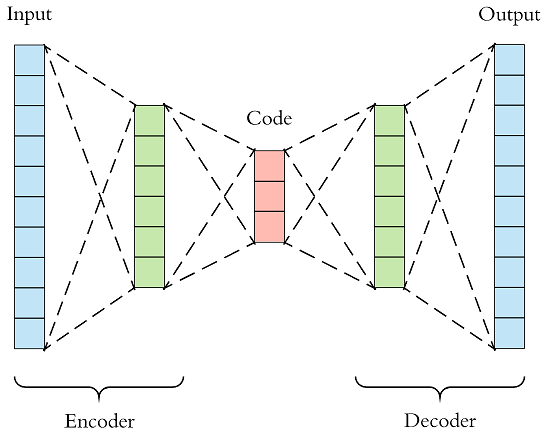

In [15]:
Image(filename='Autoencoder_architecture_pic_2.png')

In [13]:
history = autoencoder_1.fit(x=X_train, y=X_train, epochs=1, validation_data=[X_test, X_test])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 264283 samples, validate on 29365 samples
Epoch 1/1
264283/264283 [==============================] - 2023s 8ms/step - loss: -0.9794 - val_loss: -0.9937


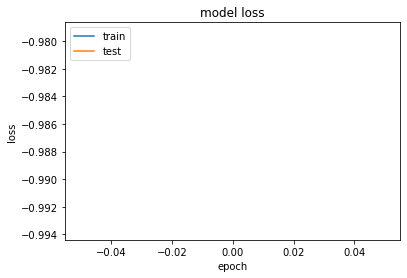

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Inference 

In [93]:
index_1 = 2
print(df['title'][index_1])
print(df['color'][index_1])
print(df['size'][index_1])

Cobb Hill Erika Slingback - Black - 6 - D - Wide
Black
6 D - Wide


In [94]:
index_2 = 3
print(df['title'][index_2])
print(df['color'][index_2])
print(df['size'][index_2])

Cobb Hill Erika Slingback - Black - 7.5 - D - Wide
Black
7.5 D - Wide


In [95]:
v_f1 = model_s.encode(df['title'][index_1])
v_f2 = model_s.encode(df['color'][index_1])
v_f3 = model_s.encode(df['size'][index_1])

v_prod_1 = np.concatenate((v_f1, v_f2, v_f3), axis=0)
v_prod_1.shape

(2304,)

In [96]:
v_f1 = model_s.encode(df['title'][index_2])
v_f2 = model_s.encode(df['color'][index_2])
v_f3 = model_s.encode(df['size'][index_2])

v_prod_2 = np.concatenate((v_f1, v_f2, v_f3), axis=0)
v_prod_2.shape

(2304,)

In [97]:
util.cos_sim(v_prod_1, v_prod_2)

tensor([[0.9150]])

In [98]:
latent_1 = encoder.predict(v_prod_1[None])[0]
reco_1 = decoder.predict(latent_1[None])[0]
print(latent_1.shape, reco_1.shape)

(1500,) (2304,)


In [99]:
latent_2 = encoder.predict(v_prod_2[None])[0]
reco_2 = decoder.predict(latent_2[None])[0]
print(latent_2.shape, reco_2.shape)

(1500,) (2304,)


In [100]:
util.cos_sim(reco_1, reco_2)  ## should be close to what we got in cos_sim(v_prod_1, v_prod_2)

tensor([[0.9410]])

In [101]:
util.cos_sim(latent_1, latent_2)  ## should be close to what we got in cos_sim(v_prod_1, v_prod_2)

tensor([[0.9098]])

In [40]:
print(util.cos_sim(reco_1, v_prod_1))  ## should be close to 1 ?
print(util.cos_sim(reco_2, v_prod_2))

tensor([[0.6677]])
tensor([[0.6330]])


In [220]:
v_f1 = model_s.encode('Nike Shoes Running, usable in rainy waterproof') 
v_f2 = model_s.encode('Black')
v_f3 = model_s.encode('3M')

latent_v_f1 = reco_1[0: 768]
latent_v_f2 = reco_1[768: 1536]
latent_v_f3 = reco_1[1536: 2304]

print(util.cos_sim(v_f1, latent_v_f1))
print(util.cos_sim(v_f2, latent_v_f2))
print(util.cos_sim(v_f3, latent_v_f3))

tensor([[0.9385]])
tensor([[0.4098]])
tensor([[0.6677]])


In [221]:
v_f1 = model_s.encode('Nike Shoes Running, usable in rainy waterproof') 
v_f2 = model_s.encode('White')
v_f3 = model_s.encode('3M')

latent_v_f1 = reco_2[0: 768]
latent_v_f2 = reco_2[768: 1536]
latent_v_f3 = reco_2[1536: 2304]

print(util.cos_sim(v_f1, latent_v_f1))
print(util.cos_sim(v_f2, latent_v_f2))
print(util.cos_sim(v_f3, latent_v_f3))

tensor([[0.9360]])
tensor([[0.4321]])
tensor([[0.6664]])


In [222]:
util.cos_sim(latent_1[0:666], latent_2[0:666])

tensor([[0.9923]])

In [227]:
df_temp = pd.read_json('data/el_zappos_6pm_pi_nocomp_52_Zappos-US_File (1).json', lines=True)

In [229]:
df_temp.head()

,sku,seed,seed_name,category,subcategory,product_type,brand,bid,status,thumbnail,seed_source,tagged_data,is_published,docs,static_data,invalid_docs
0,5650673,50418b16b45be9367212657c14a6b1cae03fc2f8,Dickies - Women's Perfect Shape Denim Jean-Ski...,Partnerships,Pants,Reverse Sharing,Dickies,280482091,0,https://www.zappos.com/images/z/5/6/5/0/6/7/56...,Zappos-US,"{'competitors': ['Skechers-US', 'Ugg-US', 'Sor...",0,[50418b16b45be9367212657c14a6b1cae03fc2f8],{'50418b16b45be9367212657c14a6b1cae03fc2f8': {}},NaN
1,2783899,d1502c72995153090b6076ca44893a19d8c99b39,PUMA Kids - Roma Basic Jr. (Big Kid) Black/Black,6pm,Sneakers & Athletic Shoes,DB Kids Footwear Lifestyle,PUMA Kids,280474015,0,https://www.6pm.com/images/z/2/1/9/9/7/5/21997...,6PM-US,"{'competitors': ['Sorel-US', 'FootLocker-US', ...",0,[d1502c72995153090b6076ca44893a19d8c99b39],{'d1502c72995153090b6076ca44893a19d8c99b39': {}},NaN
2,2961044,ef1eaf5ef0db091229163b94fc6582bb8aaf1431,bernie mev. - Halle Black,Casual Footwear Womens,Heels,Casual Footwear 2,bernie mev.,280474016,0,,6PM-US,"{'competitors': ['Sorel-US', 'FootLocker-US', ...",0,[ef1eaf5ef0db091229163b94fc6582bb8aaf1431],{'ef1eaf5ef0db091229163b94fc6582bb8aaf1431': {}},NaN
3,3277804,a6b0ae40274b6b619d32c270c7f4b04b64da11b4,Stonewear Designs - Rockin Shorts Black,Zappos Exit,Shorts,Womens Performance Apparel Exit,Stonewear Designs,280474017,0,https://www.zappos.com/images/z/3/2/7/7/8/0/32...,6PM-US,"{'competitors': ['Sorel-US', 'FootLocker-US', ...",0,[a6b0ae40274b6b619d32c270c7f4b04b64da11b4],{'a6b0ae40274b6b619d32c270c7f4b04b64da11b4': {}},NaN
4,3672296,c2f7899931a9b7eb88052ace8644c176aabcc81c,LifeStride - Sevyn Navy,Casual Footwear Womens,Heels,Casual Footwear 2,LifeStride,280474018,0,https://www.zappos.com/images/z/3/6/7/3/2/7/36...,6PM-US,"{'competitors': ['Sorel-US', 'FootLocker-US', ...",0,[c2f7899931a9b7eb88052ace8644c176aabcc81c],{'c2f7899931a9b7eb88052ace8644c176aabcc81c': {}},NaN


In [231]:
df_temp.iloc[0]

sku                                                       5650673
seed                     50418b16b45be9367212657c14a6b1cae03fc2f8
seed_name       Dickies - Women's Perfect Shape Denim Jean-Ski...
category                                             Partnerships
subcategory                                                 Pants
product_type                                      Reverse Sharing
brand                                                     Dickies
bid                                                     280482091
status                                                          0
thumbnail       https://www.zappos.com/images/z/5/6/5/0/6/7/56...
seed_source                                             Zappos-US
tagged_data     {'competitors': ['Skechers-US', 'Ugg-US', 'Sor...
is_published                                                    0
docs                   [50418b16b45be9367212657c14a6b1cae03fc2f8]
static_data      {'50418b16b45be9367212657c14a6b1cae03fc2f8': {}}
invalid_do